In [1]:
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract(
    "./Main_27.04.2023.apkg", filter_out_suspended_cards, filter_out_flags
)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False
)
optimizer.define_model()
optimizer.pretrain(verbose=False)

Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/30507 [00:00<?, ?it/s]

Trainset saved.
Pretrain finished!


[]

In [2]:
from torch import Tensor, nn
import torch
from statsmodels.nonparametric.smoothers_lowess import lowess


class ICILoss(nn.Module):
    def __init__(self):
        super(ICILoss, self).__init__()
        # self.loss_fn = nn.L1Loss(reduce="None")
        self.loss_fn = nn.MSELoss(reduce="None")

    def forward(self, predictions: Tensor, labels: Tensor) -> Tensor:
        observation = lowess(
            labels.detach().numpy(),
            predictions.detach().numpy(),
            it=0,
            delta=0.01
            * (max(predictions.detach().numpy()) - min(predictions.detach().numpy())),
            return_sorted=False,
        )
        observation = torch.as_tensor(observation, dtype=torch.float32)
        # return self.loss_fn(predictions, observation)
        return torch.sqrt(self.loss_fn(predictions, observation))

  0%|          | 0/248083 [00:00<?, ?it/s]

dataset built


train:   0%|          | 0/1756144 [00:00<?, ?it/s]

iteration: 175295
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1047, 1.1303, 0.8244, 0.044, 1.6279, 0.1372, 1.0034, 2.1312, 0.0849, 0.3194, 1.3545, 0.2177, 2.7849]
iteration: 349757
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1045, 1.1297, 0.8258, 0.0418, 1.6276, 0.139, 1.0031, 2.1309, 0.0854, 0.319, 1.3548, 0.2169, 2.7861]
iteration: 525052
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1046, 1.1294, 0.8269, 0.0397, 1.627, 0.1407, 1.0025, 2.1304, 0.0862, 0.3183, 1.3548, 0.2161, 2.7869]
iteration: 699514
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1042, 1.1288, 0.8275, 0.0385, 1.6269, 0.1418, 1.0025, 2.1305, 0.0862, 0.3183, 1.3554, 0.2158, 2.7875]
iteration: 874809
w: [0.3474, 0.3474, 1.592, 90.5314, 5.104, 1.1282, 0.8279, 0.0374, 1.6268, 0.1427, 1.0024, 2.1305, 0.0864, 0.3182, 1.3558, 0.2155, 2.7881]
iteration: 1049271
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1037, 1.1278, 0.8281, 0.0366, 1.6268, 0.1433, 1.0024, 2.1305, 0.0865, 0.3181, 1.356, 0.2153, 2.7886]
iteration: 1223733
w: [0.3474, 0.3474, 1.592, 90.5314, 5.

train:   0%|          | 0/1755200 [00:00<?, ?it/s]

iteration: 175236
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1041, 1.1293, 0.8234, 0.0445, 1.6284, 0.1368, 1.0039, 2.1322, 0.0839, 0.3204, 1.3558, 0.2179, 2.7844]
iteration: 349580
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1038, 1.1283, 0.8238, 0.0429, 1.628, 0.1384, 1.0036, 2.1328, 0.0836, 0.3207, 1.357, 0.2171, 2.7846]
iteration: 524816
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1036, 1.1275, 0.824, 0.0414, 1.6274, 0.14, 1.0031, 2.1332, 0.0834, 0.321, 1.3581, 0.2162, 2.7846]
iteration: 699160
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1031, 1.1265, 0.8241, 0.0404, 1.6273, 0.1411, 1.003, 2.1337, 0.0831, 0.3213, 1.3591, 0.2157, 2.7846]
iteration: 874396
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1027, 1.1257, 0.824, 0.0396, 1.6273, 0.1418, 1.003, 2.1342, 0.0828, 0.3217, 1.36, 0.2154, 2.7847]
iteration: 1048740
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1025, 1.1252, 0.824, 0.0389, 1.6271, 0.1425, 1.0029, 2.1344, 0.0826, 0.3219, 1.3605, 0.2151, 2.7848]
iteration: 1223084
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1023, 

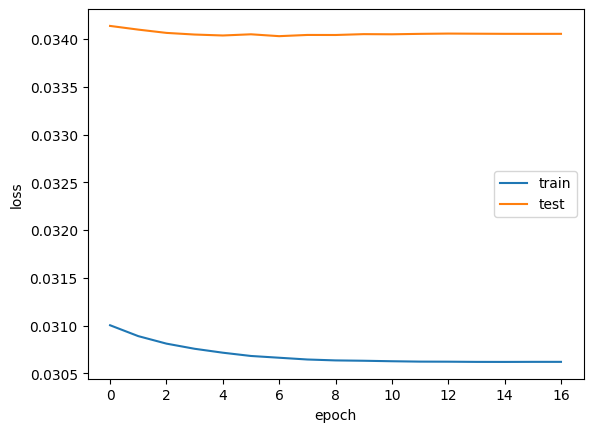

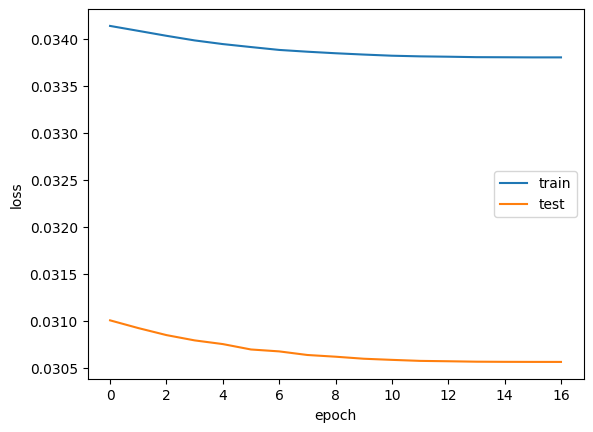

In [3]:
from fsrs_optimizer import Trainer, lineToTensor, StratifiedGroupKFold
import numpy as np

lr: float = 1e-4
n_epoch: int = 16
n_splits: int = 2
batch_size: int = 4096
verbose: bool = True

dataset = optimizer.dataset
dataset["tensor"] = dataset.progress_apply(
    lambda x: lineToTensor(list(zip([x["t_history"]], [x["r_history"]]))[0]),
    axis=1,
)
dataset["group"] = dataset["r_history"] + dataset["t_history"]

w = []
plots = []
sgkf = StratifiedGroupKFold(n_splits=n_splits)
for train_index, test_index in sgkf.split(dataset, dataset["i"], dataset["group"]):
    train_set = dataset.iloc[train_index].copy()
    test_set = dataset.iloc[test_index].copy()
    trainer = Trainer(
        train_set,
        test_set,
        optimizer.init_w,
        n_epoch=n_epoch,
        lr=lr,
        batch_size=batch_size,
    )
    trainer.loss_fn = ICILoss()
    w.append(trainer.train(verbose=verbose))
    if verbose:
        plots.append(trainer.plot())

w = np.array(w)
avg_w = np.round(np.mean(w, axis=0), 4)
optimizer.w = avg_w.tolist()

Loss before training: 0.4219
Loss after training: 0.4213
R-squared: 0.8556
RMSE: 0.0335
MAE: 0.0264
ICI: 0.0251
E50: 0.0197
E90: 0.0421
EMax: 0.2854
[0.18848656 0.76311156]

Last rating: 1
R-squared: 0.4375
RMSE: 0.0652
MAE: 0.0598
ICI: 0.0588
E50: 0.0670
E90: 0.0858
EMax: 0.1936
[0.22829869 0.67487864]

Last rating: 2
R-squared: 0.7301
RMSE: 0.0464
MAE: 0.0419
ICI: 0.0399
E50: 0.0395
E90: 0.0456
EMax: 0.2964
[0.14698561 0.78731824]

Last rating: 3
R-squared: 0.8708
RMSE: 0.0309
MAE: 0.0185
ICI: 0.0174
E50: 0.0101
E90: 0.0340
EMax: 0.2708
[0.20861617 0.7589295 ]

Last rating: 4
R-squared: -2.5873
RMSE: 0.0595
MAE: 0.0357
ICI: 0.0351
E50: 0.0248
E90: 0.0767
EMax: 0.3816
[0.63380914 0.36097131]


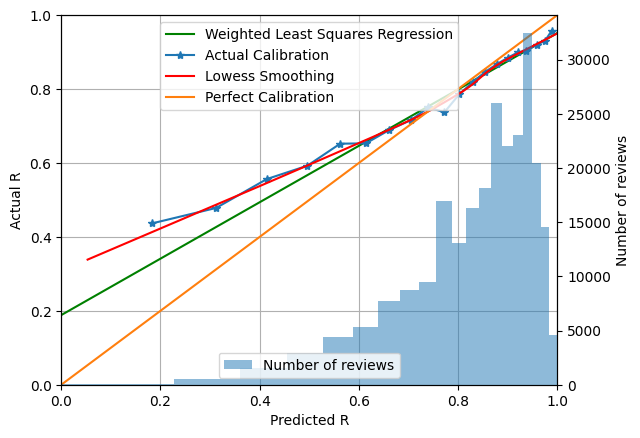

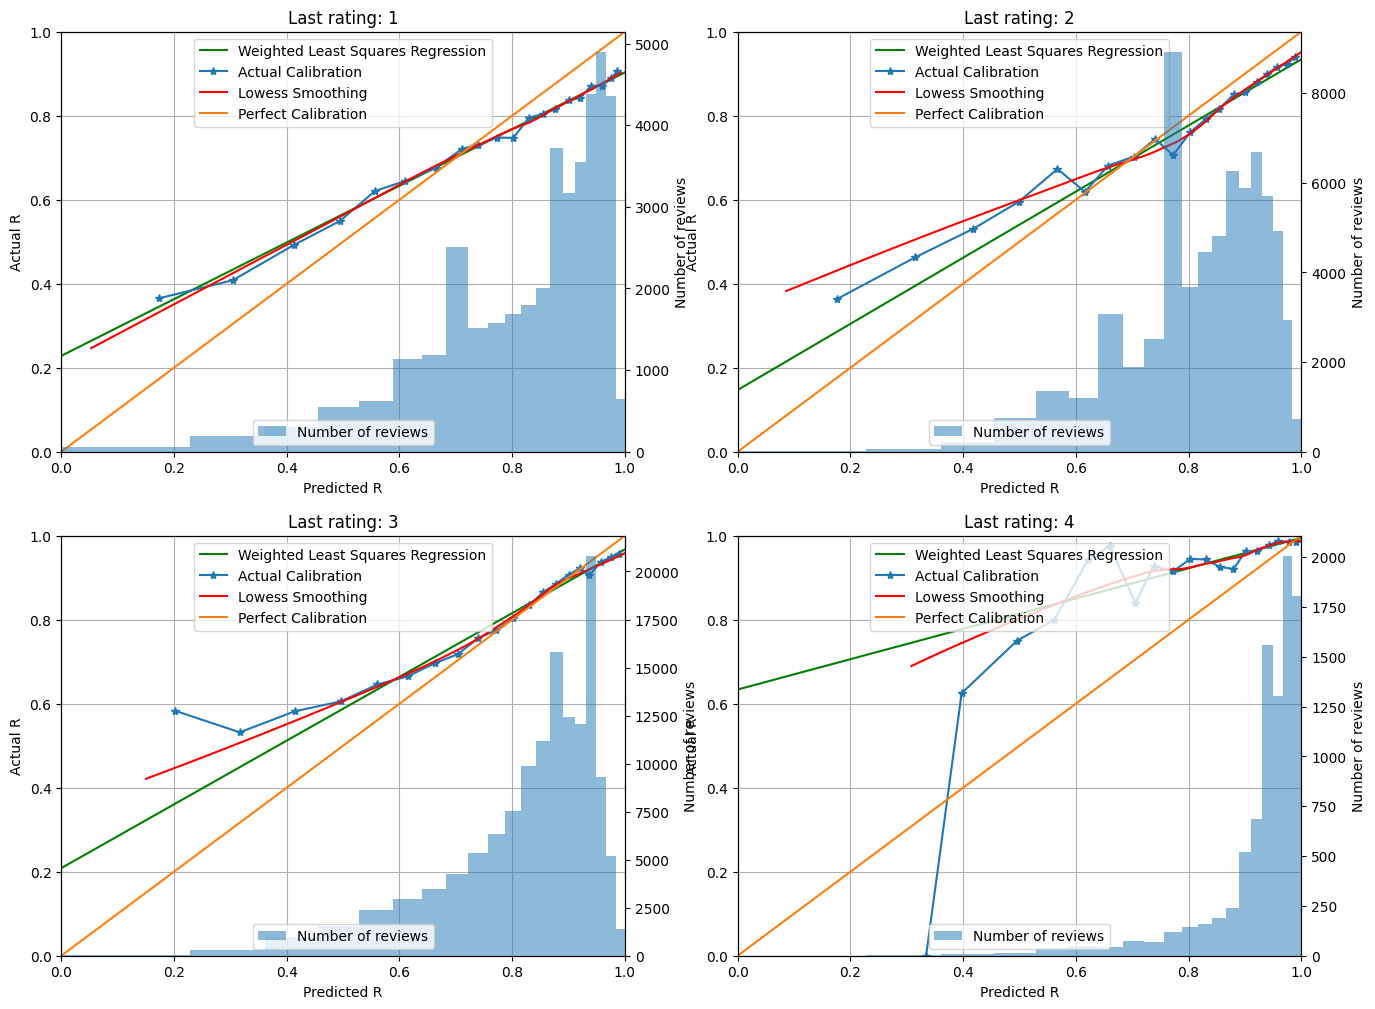

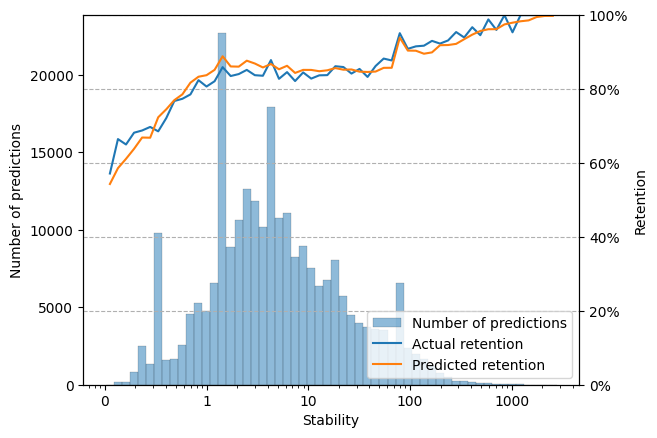

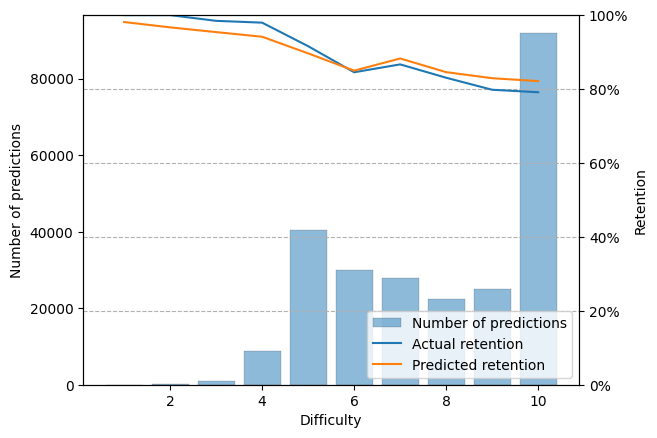

In [4]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")
metrics, figures = optimizer.calibration_graph()